In [7]:
#%matplotlib notebook
# или
%matplotlib widget

import os
import sys
import math

# Путь к директории, где находится текущий ноутбук
NOTEBOOK_DIR = os.path.abspath(os.path.dirname("__file__"))  # работает в Jupyter

# Поднимаемся на один уровень вверх – получаем корень проекта
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, os.pardir, 'src'))

# Добавляем корень в начало sys.path, если его там ещё нет
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

In [8]:
from pathlib import Path
from collections import Counter, defaultdict

from OCC.Core.gp import gp_Pnt, gp_Dir, gp_Ax2
from OCC.Core.HLRAlgo import HLRAlgo_Projector
from OCC.Core.HLRBRep import HLRBRep_Algo, HLRBRep_HLRToShape
from OCC.Core.TopExp import TopExp_Explorer
from OCC.Core.TopAbs import TopAbs_EDGE

from OCC.Core.GeomAbs import (
    GeomAbs_Line,
    GeomAbs_Circle,
    GeomAbs_Ellipse,
    GeomAbs_BSplineCurve,
    GeomAbs_BezierCurve,
    GeomAbs_OtherCurve,
)

from OCC.Core.BRepAdaptor import BRepAdaptor_Curve
from OCC.Core.GCPnts import GCPnts_AbscissaPoint

from afr3d.io.step_import import extract_solids, load_step


# ---------- HLR-проекция ----------

def build_hlr_projection(shape,
                         view_dir=(0, 0, 1),
                         up_dir=(0, 1, 0)):
    """
    Строит HLR-проекцию для заданного направления взгляда.
    """
    origin = gp_Pnt(0.0, 0.0, 0.0)
    dir_v = gp_Dir(*view_dir)
    up_v = gp_Dir(*up_dir)

    ax2 = gp_Ax2(origin, dir_v, up_v)
    projector = HLRAlgo_Projector(ax2)

    algo = HLRBRep_Algo()
    algo.Add(shape)
    algo.Projector(projector)     # или algo.SetProjector(projector) в старых версиях
    algo.Update()                 # построение "видимых" проекций
    algo.Hide()                   # расчёт скрытых

    hlr_shapes = HLRBRep_HLRToShape(algo)

    result = {
        "visible": hlr_shapes.VCompound(),
        "hidden": hlr_shapes.HCompound(),
        "outline_visible": hlr_shapes.OutLineVCompound(),
        "outline_hidden": hlr_shapes.OutLineHCompound(),
        "iso_visible": hlr_shapes.IsoLineVCompound(),
        "iso_hidden": hlr_shapes.IsoLineHCompound(),
    }
    return result


def count_edges(shape):
    if shape.IsNull():
        return 0
    exp = TopExp_Explorer(shape, TopAbs_EDGE)
    n = 0
    while exp.More():
        n += 1
        exp.Next()
    return n


# ---------- тип кривой + статистика ----------

def curve_type_name(geom_type: int) -> str:
    mapping = {
        GeomAbs_Line: "line",
        GeomAbs_Circle: "circle",
        GeomAbs_Ellipse: "ellipse",
        GeomAbs_BSplineCurve: "bspline",
        GeomAbs_BezierCurve: "bezier",
        GeomAbs_OtherCurve: "other",
    }
    return mapping.get(geom_type, f"unknown({int(geom_type)})")


def compute_curve_length(edge):
    """
    Универсальный способ вычислить длину кривой через адаптер и интегратор.
    Работает для линий, дуг, b-spline и всего прочего.
    """

    try:
        bac = BRepAdaptor_Curve(edge)
    except Exception:
        return 0.0

    try:
        first = bac.FirstParameter()
        last  = bac.LastParameter()
    except Exception:
        return 0.0

    if last <= first:
        return 0.0

    # длина через точную абсциссу (численный интеграл по параметрам)
    try:
        length = GCPnts_AbscissaPoint.Length(bac, first, last)
        return float(length)
    except Exception:
        return 0.0


def analyze_curve_stats(compound_shape):
    counts = Counter()
    lengths = defaultdict(float)

    if compound_shape is None or compound_shape.IsNull():
        return counts, lengths

    exp = TopExp_Explorer(compound_shape, TopAbs_EDGE)
    while exp.More():
        edge = exp.Current()

        try:
            bac = BRepAdaptor_Curve(edge)
            ctype = bac.GetType()
        except Exception:
            exp.Next()
            continue

        name = curve_type_name(ctype)
        counts[name] += 1

        # длина
        length = compute_curve_length(edge)
        lengths[name] += length

        exp.Next()

    return counts, lengths

In [9]:
step_path = Path("../data/example_complex.stp")
shape_raw = load_step(step_path)
shape = extract_solids(shape_raw)

print("В исходном shape рёбер:", count_edges(shape))

projection = build_hlr_projection(shape, view_dir=(0, 0, -1), up_dir=(0, 1, 0))

for name, shp in projection.items():
    if shp is not None:
        print(f"{name}: IsNull={shp.IsNull()}, edges={count_edges(shp)}")
    else:
        print(f"{name}: {type(projection['outline_visible'])}")

visible = projection["visible"]
hidden = projection["hidden"]
outline_hidden = projection["outline_hidden"]

vis_counts, vis_lengths = analyze_curve_stats(visible)
hid_counts, hid_lengths = analyze_curve_stats(hidden)
ol_hid_counts, ol_hid_lengths = analyze_curve_stats(outline_hidden)

print("=== Visible edges ===")
print("by type:", vis_counts)
print("lengths:", dict(vis_lengths))

print("=== Hidden edges ===")
print("by type:", hid_counts)
print("lengths:", dict(hid_lengths))

print("=== Outline hidden edges ===")
print("by type:", ol_hid_counts)
print("lengths:", dict(ol_hid_lengths))

В исходном shape рёбер: 785
visible: IsNull=False, edges=59
hidden: IsNull=False, edges=213
outline_visible: <class 'NoneType'>
outline_hidden: IsNull=False, edges=25
iso_visible: <class 'NoneType'>
iso_hidden: <class 'NoneType'>
=== Visible edges ===
by type: Counter({'ellipse': 33, 'line': 15, 'bspline': 9, 'circle': 2})
lengths: {'line': 670.2257054320352, 'ellipse': 1022.8536431343014, 'bspline': 95.16684850835016, 'circle': 30.18348992521758}
=== Hidden edges ===
by type: Counter({'bspline': 76, 'line': 71, 'ellipse': 51, 'circle': 15})
lengths: {'line': 2450.9137344330816, 'bspline': 642.2769339844247, 'circle': 201.08746087218915, 'ellipse': 978.0719553459155}
=== Outline hidden edges ===
by type: Counter({'line': 16, 'bspline': 9})
lengths: {'line': 247.48907285930784, 'bspline': 167.7818060228175}


В исходном shape рёбер: 785
visible: IsNull=False, edges=59
hidden: IsNull=False, edges=213
outline_visible: None
outline_hidden: IsNull=False, edges=25
iso_visible: None
iso_hidden: None


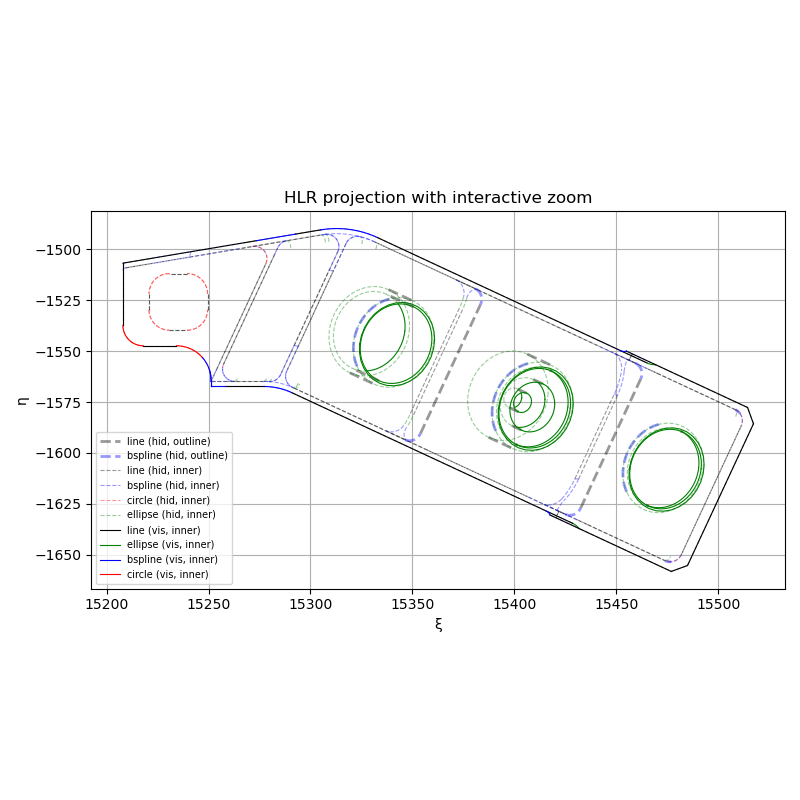

In [10]:
from pathlib import Path
from collections import defaultdict

import matplotlib.pyplot as plt

from OCC.Core.STEPControl import STEPControl_Reader
from OCC.Core.IFSelect import IFSelect_RetDone
from OCC.Core.gp import gp_Pnt, gp_Dir, gp_Ax2, gp_Vec
from OCC.Core.HLRAlgo import HLRAlgo_Projector
from OCC.Core.HLRBRep import HLRBRep_Algo, HLRBRep_HLRToShape
from OCC.Core.TopExp import TopExp_Explorer
from OCC.Core.TopAbs import TopAbs_EDGE
from OCC.Core.BRepAdaptor import BRepAdaptor_Curve
from OCC.Core.GeomAbs import (
    GeomAbs_Line,
    GeomAbs_Circle,
    GeomAbs_Ellipse,
    GeomAbs_BSplineCurve,
    GeomAbs_BezierCurve,
    GeomAbs_OtherCurve,
)


# ---------- STEP ----------

def load_step_shape(path: str):
    reader = STEPControl_Reader()
    status = reader.ReadFile(str(path))
    if status != IFSelect_RetDone:
        raise RuntimeError(f"STEP read failed: {path}")
    reader.TransferRoots()
    shape = reader.OneShape()
    return shape


# ---------- HLR-проекция ----------

def build_hlr_projection(shape,
                         view_dir=(0, 0, 1),
                         up_dir=(0, 1, 0)):
    origin = gp_Pnt(0.0, 0.0, 0.0)
    dir_v = gp_Dir(*view_dir)
    up_v = gp_Dir(*up_dir)
    ax2 = gp_Ax2(origin, dir_v, up_v)

    projector = HLRAlgo_Projector(ax2)

    algo = HLRBRep_Algo()
    algo.Add(shape)
    algo.Projector(projector)
    algo.Update()
    algo.Hide()

    hlr_shapes = HLRBRep_HLRToShape(algo)

    projection = {
        "visible": hlr_shapes.VCompound(),
        "hidden": hlr_shapes.HCompound(),
        "outline_visible": hlr_shapes.OutLineVCompound(),
        "outline_hidden": hlr_shapes.OutLineHCompound(),
        "iso_visible": hlr_shapes.IsoLineVCompound(),
        "iso_hidden": hlr_shapes.IsoLineHCompound(),
    }
    return projection, ax2


def count_edges(shape):
    if shape is None or shape.IsNull():
        return 0
    exp = TopExp_Explorer(shape, TopAbs_EDGE)
    n = 0
    while exp.More():
        n += 1
        exp.Next()
    return n


# ---------- 3D→2D и дискретизация ----------

def curve_type_name(geom_type: int) -> str:
    mapping = {
        GeomAbs_Line: "line",
        GeomAbs_Circle: "circle",
        GeomAbs_Ellipse: "ellipse",
        GeomAbs_BSplineCurve: "bspline",
        GeomAbs_BezierCurve: "bezier",
        GeomAbs_OtherCurve: "other",
    }
    return mapping.get(geom_type, f"unknown({int(geom_type)})")


def project_point_to_view_2d(pnt: gp_Pnt, ax2: gp_Ax2):
    origin = ax2.Location()
    vx = gp_Vec(ax2.XDirection())
    vy = gp_Vec(ax2.YDirection())
    v = gp_Vec(origin, pnt)
    x = vx.Dot(v)
    y = vy.Dot(v)
    return x, y


def sample_edge_2d(edge, ax2: gp_Ax2, n_samples=32):
    pts_2d = []
    try:
        bac = BRepAdaptor_Curve(edge)
    except Exception:
        return pts_2d

    try:
        first = bac.FirstParameter()
        last = bac.LastParameter()
    except Exception:
        return pts_2d

    if last <= first:
        return pts_2d

    if bac.GetType() == GeomAbs_Line:
        params = [first, last]
    else:
        params = [first + (last - first) * i / (n_samples - 1) for i in range(n_samples)]

    for u in params:
        try:
            p3d = bac.Value(u)
        except Exception:
            continue
        x, y = project_point_to_view_2d(p3d, ax2)
        pts_2d.append((x, y))

    return pts_2d


# ---------- Рисование ----------

COLOR_BY_TYPE = {
    "line": "black",
    "circle": "red",
    "ellipse": "green",
    "bspline": "blue",
    "bezier": "magenta",
    "other": "orange",
}

def draw_compound_by_type(ax, compound, ax2: gp_Ax2,
                          visible=True,
                          is_outline=False):
    if compound is None or compound.IsNull():
        return

    exp = TopExp_Explorer(compound, TopAbs_EDGE)
    legend_done = set()

    while exp.More():
        edge = exp.Current()
        exp.Next()

        try:
            bac = BRepAdaptor_Curve(edge)
            ctype = bac.GetType()
        except Exception:
            continue

        tname = curve_type_name(ctype)
        color = COLOR_BY_TYPE.get(tname, "gray")

        pts_2d = sample_edge_2d(edge, ax2)
        if len(pts_2d) < 2:
            continue

        xs = [p[0] for p in pts_2d]
        ys = [p[1] for p in pts_2d]

        linestyle = "-" if visible else "--"
        alpha = 1.0 if visible else 0.4
        linewidth = 2.0 if is_outline else 0.8

        legend_key = (tname, visible, is_outline)
        label = None
        if legend_key not in legend_done:
            vis_str = "vis" if visible else "hid"
            outline_str = "outline" if is_outline else "inner"
            label = f"{tname} ({vis_str}, {outline_str})"
            legend_done.add(legend_key)

        ax.plot(xs, ys,
                color=color,
                linestyle=linestyle,
                alpha=alpha,
                linewidth=linewidth,
                label=label)


# ---------- Интерактивный зум (колёсико мыши) ----------

def connect_scroll_zoom(fig, ax, base_scale=1.2):
    """
    Подключает зум по колесику мыши: приближение/отдаление вокруг курсора.
    """

    def on_scroll(event):
        if event.inaxes != ax:
            return

        xdata = event.xdata
        ydata = event.ydata
        if xdata is None or ydata is None:
            return

        cur_xmin, cur_xmax = ax.get_xlim()
        cur_ymin, cur_ymax = ax.get_ylim()

        x_range = (cur_xmax - cur_xmin)
        y_range = (cur_ymax - cur_ymin)

        if event.button == "up":
            # zoom in
            scale_factor = 1 / base_scale
        elif event.button == "down":
            # zoom out
            scale_factor = base_scale
        else:
            return

        new_x_range = x_range * scale_factor
        new_y_range = y_range * scale_factor

        # центрируем зум относительно курсора
        ax.set_xlim([xdata - new_x_range * (xdata - cur_xmin) / x_range,
                     xdata + new_x_range * (cur_xmax - xdata) / x_range])
        ax.set_ylim([ydata - new_y_range * (ydata - cur_ymin) / y_range,
                     ydata + new_y_range * (cur_ymax - ydata) / y_range])

        fig.canvas.draw_idle()

    fig.canvas.mpl_connect("scroll_event", on_scroll)


# ---------- main ----------

if __name__ == "__main__":
    # 1. Загружаем модель
    step_path = Path("../data/example_complex.stp")
    shape_raw = load_step(step_path)
    shape = extract_solids(shape_raw)

    print("В исходном shape рёбер:", count_edges(shape))

    # 2. HLR-проекция
    projection, ax2 = build_hlr_projection(
        shape,
        view_dir=(0, 0, -1),
        up_dir=(0, 1, 0),
    )

    visible = projection["visible"]
    hidden = projection["hidden"]
    outline_visible = projection["outline_visible"]
    outline_hidden = projection["outline_hidden"]

    for name, shp in projection.items():
        info = "None" if shp is None else f"IsNull={shp.IsNull()}, edges={count_edges(shp)}"
        print(f"{name}: {info}")

    # 3. Рисуем
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect("equal", "box")
    ax.set_title("HLR projection with interactive zoom")

    # сначала скрытые, потом видимые
    draw_compound_by_type(ax, outline_hidden, ax2,
                          visible=False, is_outline=True)
    draw_compound_by_type(ax, hidden, ax2,
                          visible=False, is_outline=False)
    draw_compound_by_type(ax, outline_visible, ax2,
                          visible=True, is_outline=True)
    draw_compound_by_type(ax, visible, ax2,
                          visible=True, is_outline=False)

    ax.grid(True)
    ax.set_xlabel("ξ")
    ax.set_ylabel("η")

    # подключаем зум колесом
    connect_scroll_zoom(fig, ax)

    # плюс стандартные инструменты тулбара (панорама/зум прямоугольником)
    ax.legend(loc="best", fontsize=7)
    plt.tight_layout()
    plt.show()